# Content similarity for Swissinfo
- Content similarity
    - In order to make a recommendation,when a user reads an article AND  we don't have any data on the user, we can make it based on content of the actual text.  
    - We can process the whole corpus and see which texts are "close" to each other because the use the same vocabulary. We can use this distance information to then recommend similar articles automatically. 
    - This works well for articles where the redactors don't have time to do the matching by hand. 

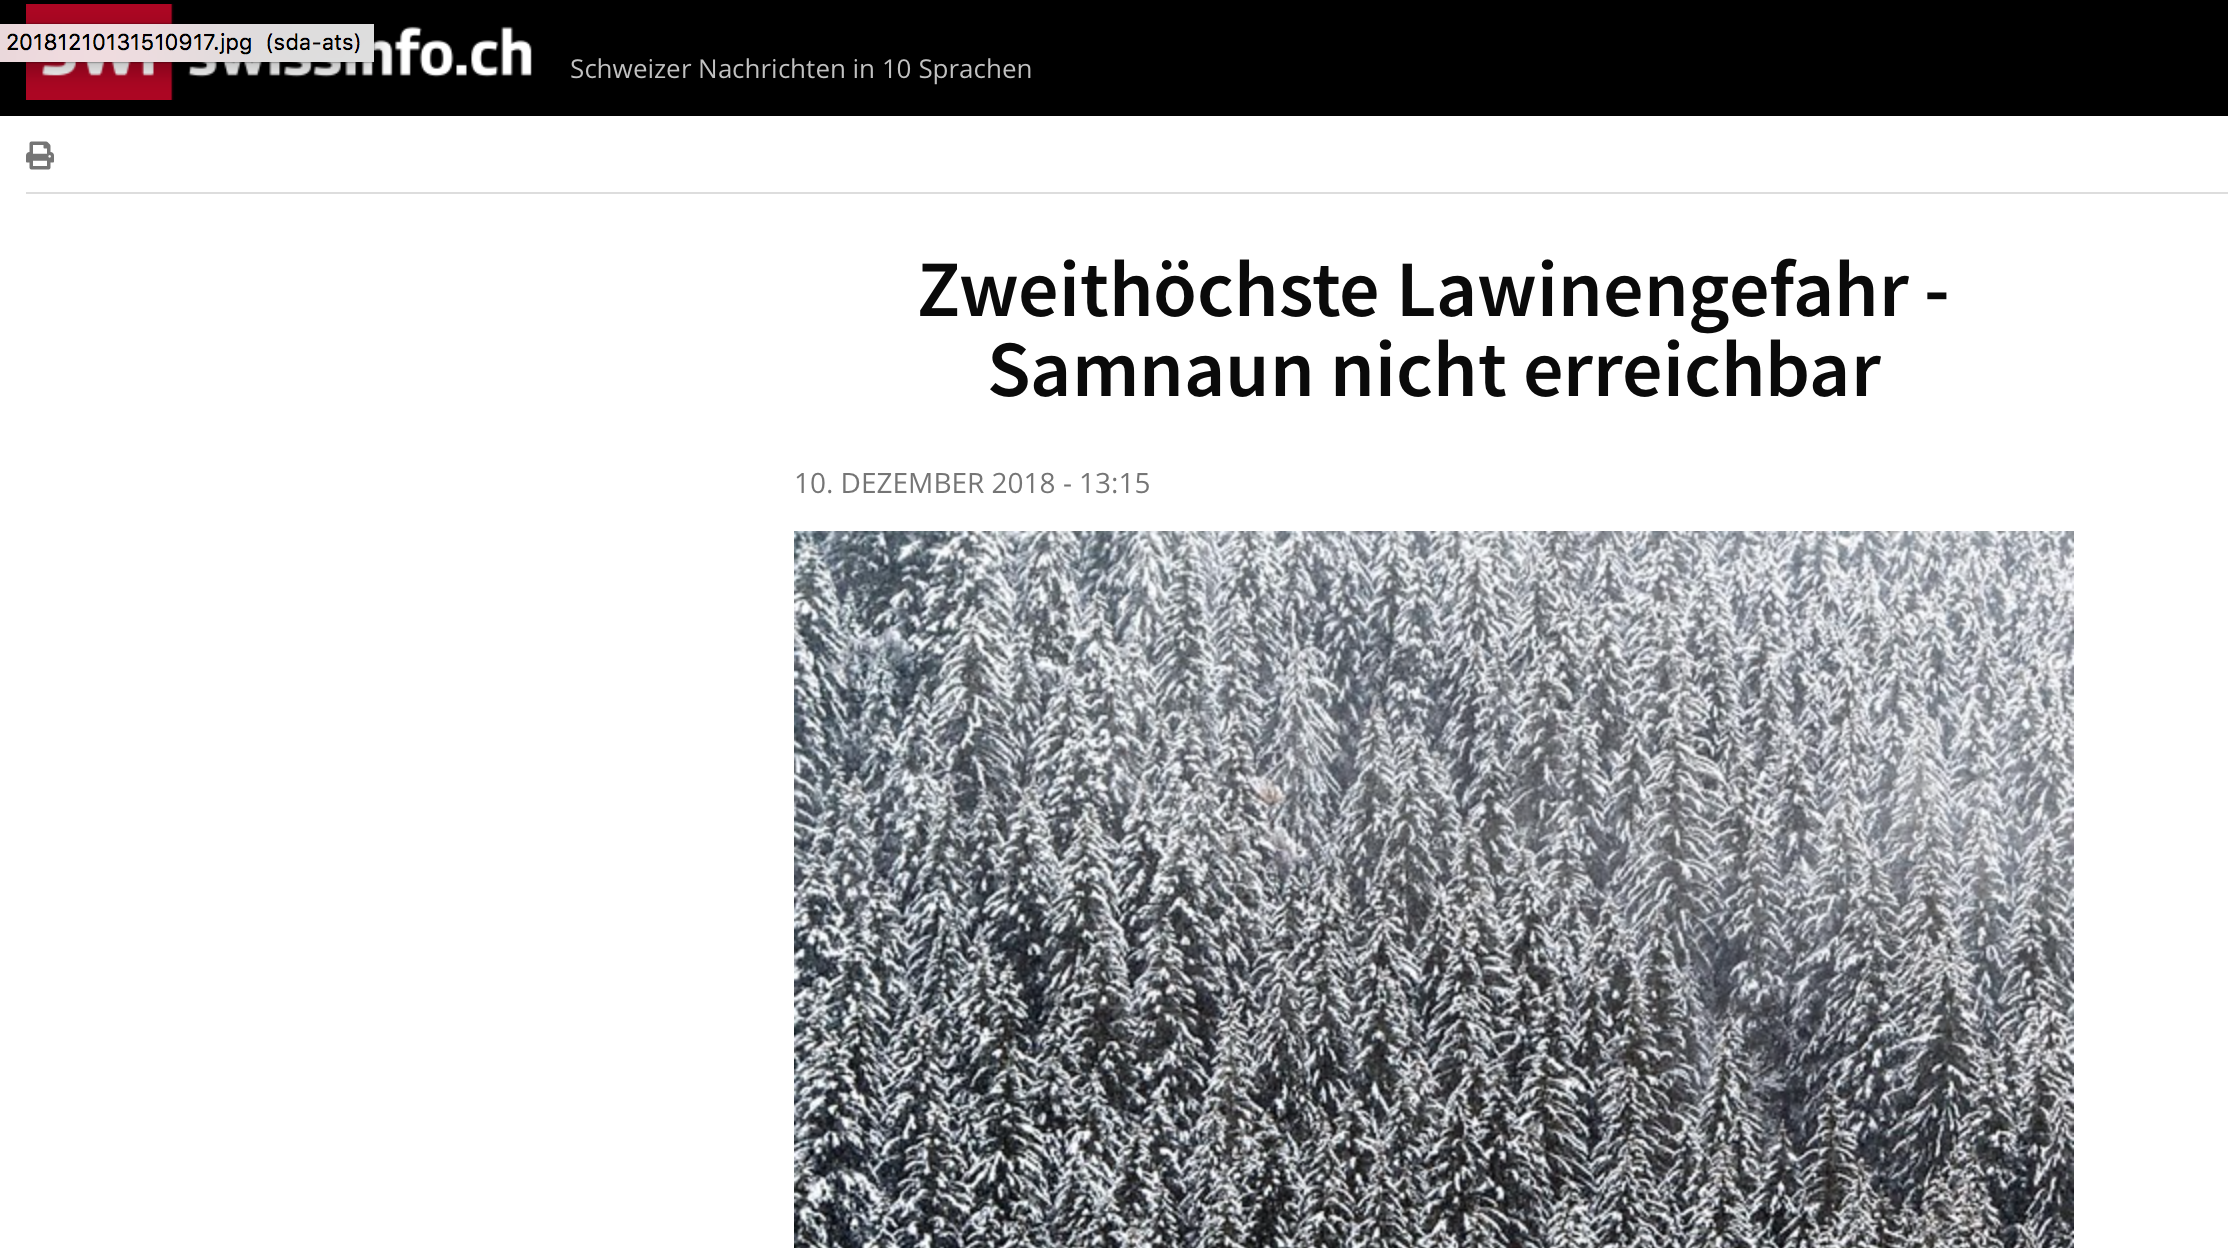

In [33]:
from IPython.display import Image
Image(filename='news.png') 

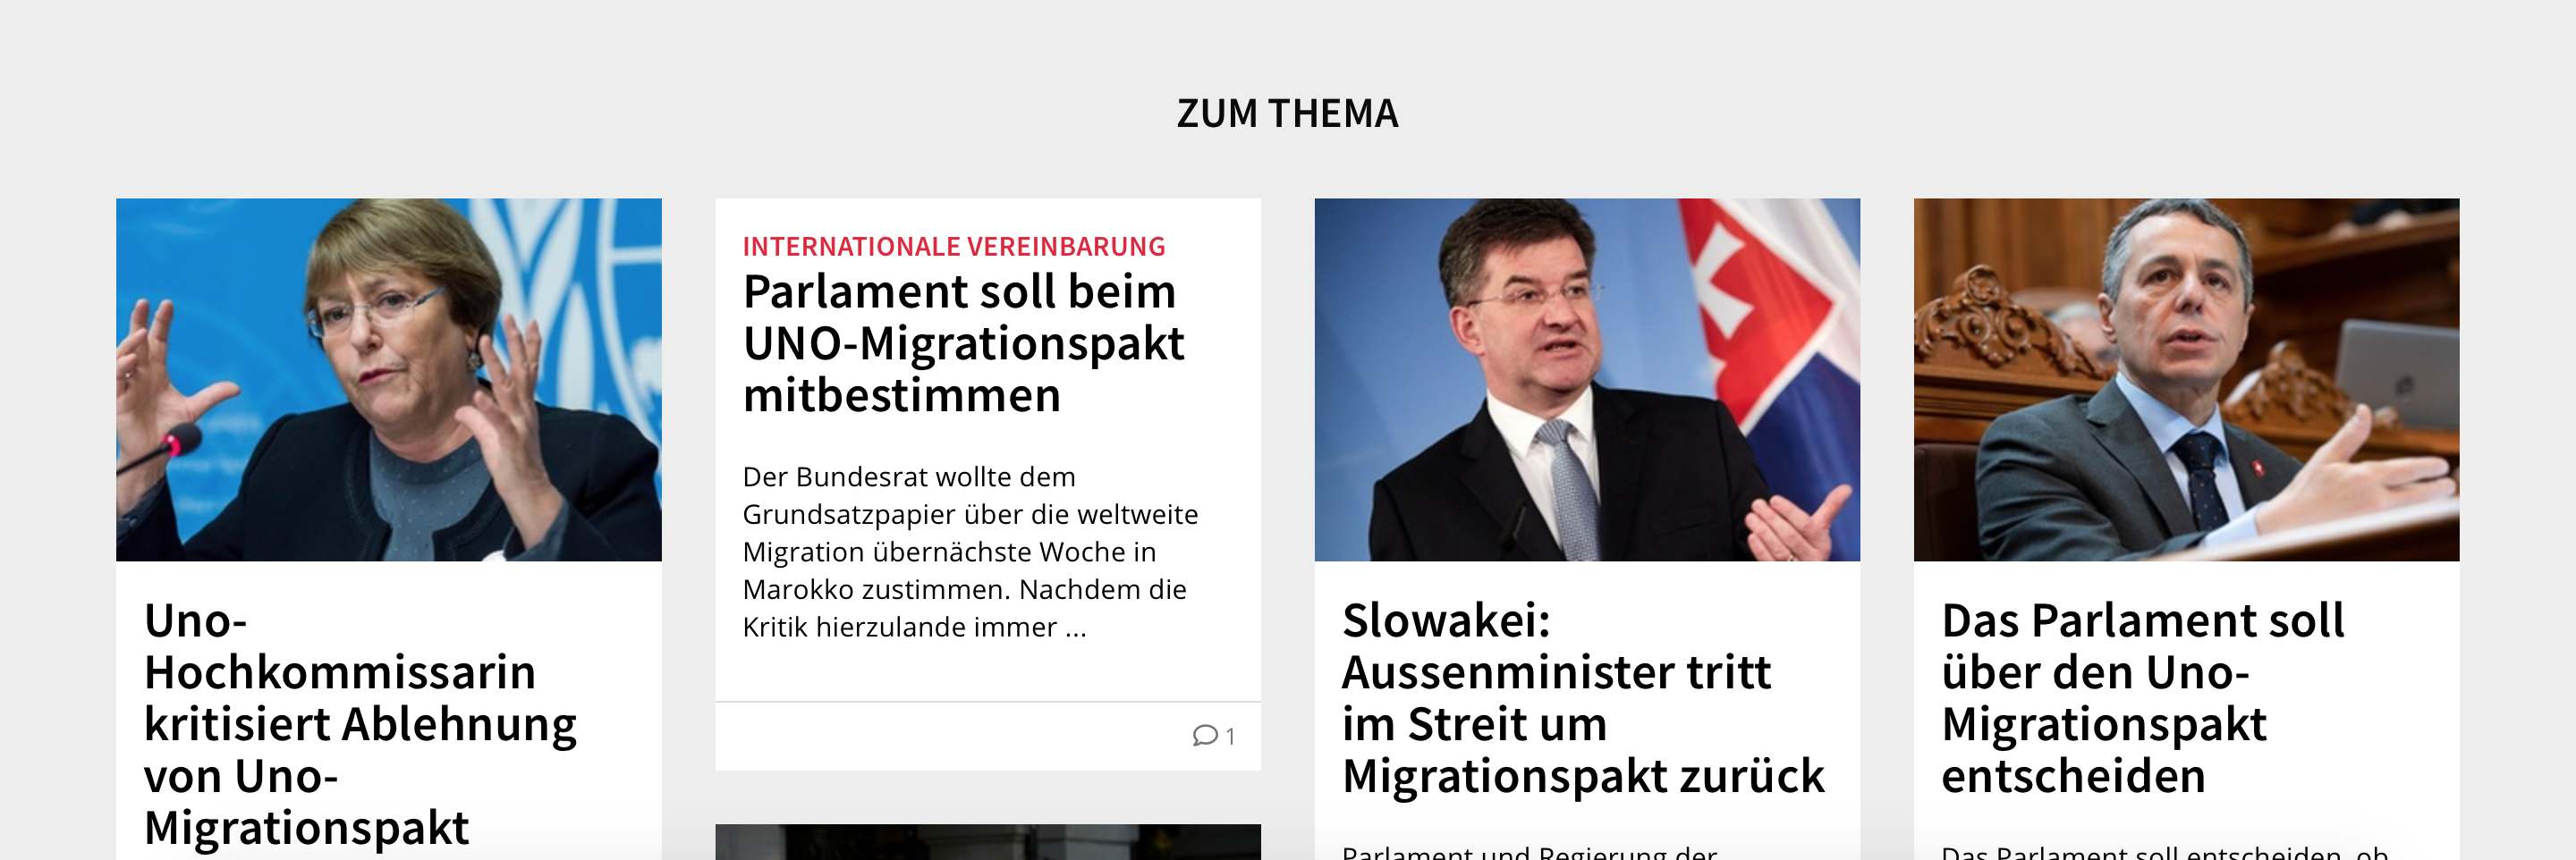

In [35]:
Image(filename='match.png') 

# vs

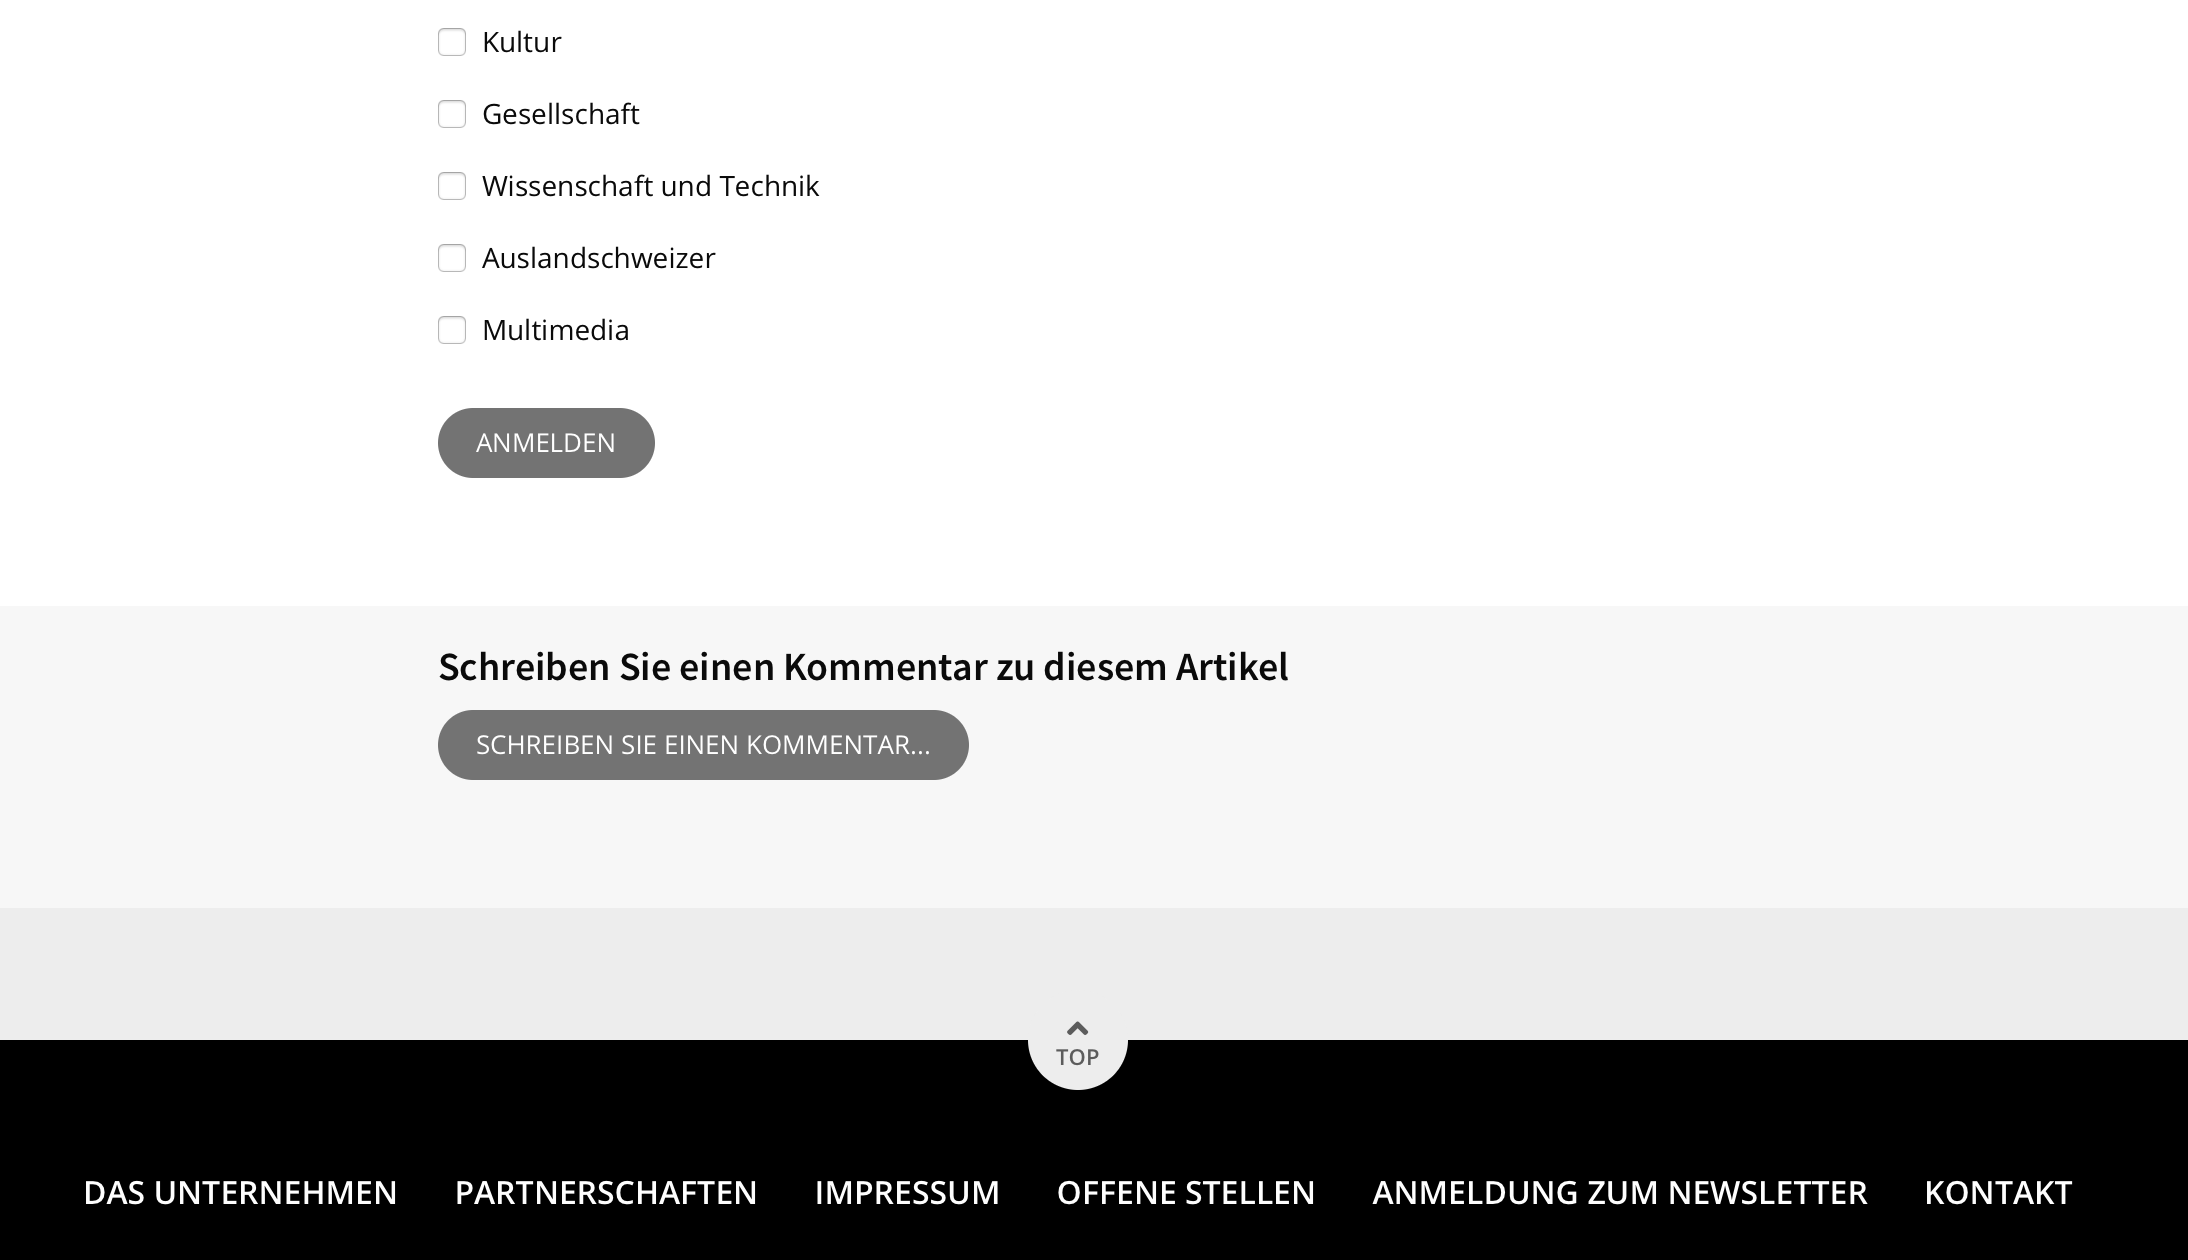

In [34]:
Image(filename='missing.png') 

# Content similarity of articles on front page

In [37]:
import requests
from bs4 import BeautifulSoup
frontpage_url = "https://www.swissinfo.ch/webservice/swi-eng-2.0/overview"
r = requests.get(frontpage_url).json()

- Info for Hubert: You have discontinued the API https://www.swissinfo.ch/webservice/chatbotize-eng-2.0/detail

In [38]:
# Get 100 Frontpage Items
items = []
urls = []
for item in r["page"]["item"][0]["content"]:
    try:
        tmp = requests.get("https://www.swissinfo.ch/webservice/swi-eng-2.0/detail%s" % item["url"])
        text = BeautifulSoup(tmp.json()["htmldetail"], "lxml").get_text()
        items.append(text)
        urls.append(item["canonical"])
        print("Done: %s" % item["url"])
    except:
        pass

Done: /webservice/swi-eng-2.0/detail/42579872/44572400
Done: /webservice/swi-eng-2.0/detail/42579872/44607262
Done: /webservice/swi-eng-2.0/detail/42579872/44595620
Done: /webservice/swi-eng-2.0/gallery/42579876/44592598
Done: /webservice/swi-eng-2.0/detail/42579872/44602420
Done: /webservice/swi-eng-2.0/video/42579874/44577612
Done: /webservice/swi-eng-2.0/detail/42579872/44601990
Done: /webservice/swi-eng-2.0/detail/42579872/44603100
Done: /webservice/swi-eng-2.0/detail/42579872/44600416
Done: /webservice/swi-eng-2.0/video/42579874/44599364
Done: /webservice/swi-eng-2.0/detail/42579872/44601712
Done: /webservice/swi-eng-2.0/detail/42579872/44597062
Done: /webservice/swi-eng-2.0/video/42579874/44572920
Done: /webservice/swi-eng-2.0/detail/42579872/44591246
Done: /webservice/swi-eng-2.0/detail/42579872/44599910
Done: /webservice/swi-eng-2.0/detail/42579872/44596456
Done: /webservice/swi-eng-2.0/detail/42579872/44598416
Done: /webservice/swi-eng-2.0/detail/42579872/44594062
Done: /webse

In [39]:
items[0][0:300]

u'    Why do we need the Global Compact for Migration? - SWI swissinfo.ch             A Honduran child cries while her mother is searched in McAllen, Texas, near the US-Mexico border\xa0on June 12, 2018; they were part of a group of immigrants who had rafted across the Rio Grande River from Mexico.(John '

In [14]:
urls[0]

u'https://www.swissinfo.ch/eng/society/global-warming_alpine-nations-struggle-to-confront-climate-change-together/44595620'

### Process Data

- Tokenize Text
- Stem Text
- Remove Stopwords

In [40]:
import collections
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
import seaborn as sns

def word_tokenizer(text):
        #tokenizes and stems the text
        tokens = word_tokenize(text)
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens if t not in stopwords.words('english')]
        return tokens


def get_similarity(items):
        tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenizer,
                                        stop_words=stopwords.words('english'),
                                        lowercase=True)
        #builds a tf-idf matrix for the sentences
        tfidf_matrix = tfidf_vectorizer.fit_transform(items)
        
        # Show matrix
        pairwise_similarity = tfidf_matrix * tfidf_matrix.T
        ax = sns.heatmap(pairwise_similarity.A)
        ax.plot()
        return pairwise_similarity

## Baby Example: Lets look how it works?

How does the result look for:
- 2 sentences with nature
- 2 sentences with apple
- 1 sentence with apple and nature
- 1 sentence with computers

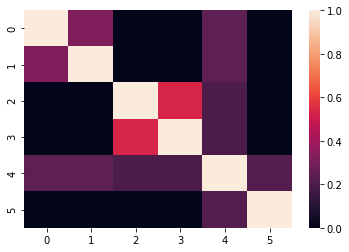

In [41]:
baby_items = ["Nature is beautiful",
              "We should protect nature",
              "I like green apples", 
              "Green apples are tasty",
              "Apples and nature are fun.",
              "Technical sentence with computers."]
result = get_similarity(baby_items)


In [42]:
result.todense()

matrix([[1.        , 0.32400299, 0.        , 0.        , 0.24294885,
         0.        ],
        [0.32400299, 1.        , 0.        , 0.        , 0.24294885,
         0.        ],
        [0.        , 0.        , 1.        , 0.53525551, 0.2014418 ,
         0.        ],
        [0.        , 0.        , 0.53525551, 1.        , 0.2014418 ,
         0.        ],
        [0.24294885, 0.24294885, 0.2014418 , 0.2014418 , 1.        ,
         0.216324  ],
        [0.        , 0.        , 0.        , 0.        , 0.216324  ,
         1.        ]])

### Lets do it for our frontpage items

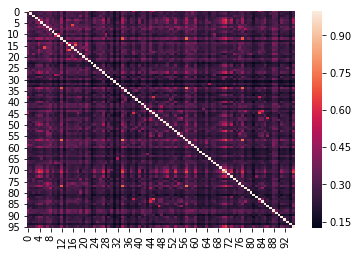

In [43]:
parwise_similarity = get_similarity(items)

In [29]:
index = 0
article = urls[index]
article

u'https://www.swissinfo.ch/eng/society/global-warming_alpine-nations-struggle-to-confront-climate-change-together/44595620'

In [31]:
import numpy as np
import heapq as heapq
distances = parwise_similarity.todense()[0].tolist()[index]
closest_match = heapq.nlargest(2, distances)[1]
urls[distances.index(closest_match)]

u'https://www.swissinfo.ch/eng/society/climate-change_torrid-time-predicted-for-switzerland-by-2060/44590274'

### Woho! The two articles are really covering a very similar thing. We could recommend them to the user when they are reading one of those. Yeay!